In [1]:
from allennlp.common import Params
from allennlp.models import Model
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data import Vocabulary
from allennlp.data.dataset import Batch

from typing import Tuple, List, Dict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np

In [4]:
from allennlp.common.util import import_submodules
import_submodules('al2_implementation')

In [5]:
prefix = '/home/emelyanov-yi/models/ontonotes/mrc_al2/bert_lstm/'
params = Params.from_file(prefix + 'config.json')
vocab = Vocabulary.from_files(prefix + 'vocabulary/')
reader = DatasetReader.from_params(params['dataset_reader'].duplicate())

In [6]:
data_path = params['validation_data_path']

In [7]:
model = Model.load(params.duplicate(), serialization_dir=prefix)

In [8]:
instances_gen = list(reader.read(data_path))

In [9]:
idx = 2550

In [20]:
custom_instance = reader.text_to_instance(
    ["Apple.", "Inc.", "stock", "prices", "are", "12", "dollars", "each", "in", "United", "States"],
    ['stock', 'price', ',', 'quantity'],
    [6],
    [7],
    type='random'
)

In [21]:
inst = custom_instance

In [22]:
batch = Batch([custom_instance])
batch.index_instances(vocab)
res = model.forward_on_instance(custom_instance)

In [17]:
idx += 1

In [18]:
inst = instances_gen[idx]
batch = Batch([inst])
batch.index_instances(vocab)
res = model.forward_on_instance(inst)

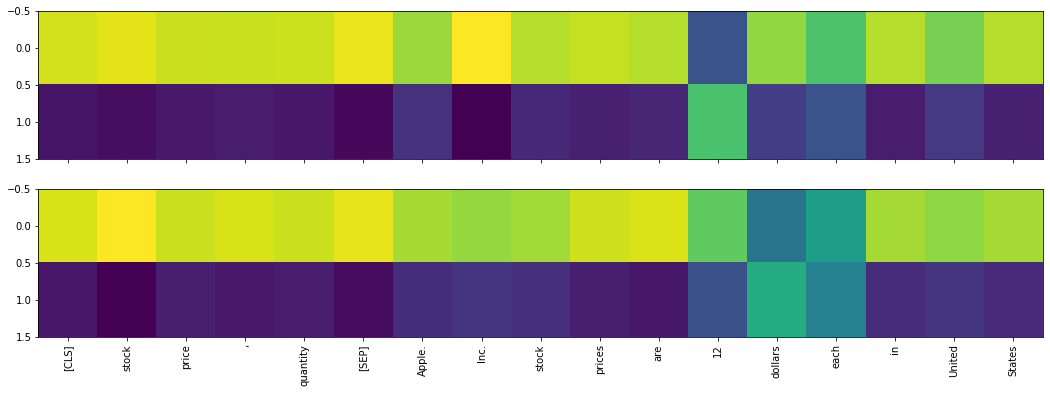

-----------Gold and prediction
[CLS] stock price , quantity [SEP] Apple. Inc. stock prices are 12  dollars each  in United States
[CLS] stock price , quantity [SEP] Apple. Inc. stock prices are  12 dollars  each in United States
------------------Meta------------
Instance with fields:
 	 context: TextField of length 17 with text: 
 		[[CLS], stock, price, ,, quantity, [SEP], Apple., Inc., stock, prices, are, 12, dollars, each, in,
		United, States]
 		and TokenIndexers : {'tokens': 'PretrainedBertIndexer'} 
 	 meta: MetadataField (print field.metadata to see specific information). 
 	 answer_starts: SequenceLabelField of length 17 with labels:
 		[False, False, False, False, False, False, False, False, False, False, False, False, True, False,
		False, False, False]
 		in namespace: 'labels'. 
 	 answer_ends: SequenceLabelField of length 17 with labels:
 		[False, False, False, False, False, False, False, False, False, False, False, False, False, True,
		False, False, False]
 		in names

In [23]:
# plt.figure(figsize=(18, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(18, 6)
ax1.imshow(res['start_logits'].T, aspect='auto')

ax2.imshow(res['end_logits'].T, aspect='auto')
n_tokens = len(inst['context'].tokens)
ax2.set_xticks(np.linspace(0, n_tokens-1, n_tokens))
ax2.set_xticklabels(inst['context'].tokens, rotation=90)
plt.show();

print('-----------Gold and prediction')

gold_spans = get_spans_from_arrays(inst['answer_starts'].labels, inst['answer_ends'].labels)
print(highlight_answers(inst['context'], gold_spans))

predicted_spans = get_spans_from_arrays(res['start_logits'].argmax(axis=1), res['end_logits'].argmax(axis=1))
print(highlight_answers(inst['context'], predicted_spans))

print('------------------Meta------------')
print(inst)
print(inst['meta'].metadata['type'])

print('------------Prediction----------')
print(res['start_logits'].argmax(axis=1))
print(res['end_logits'].argmax(axis=1))

In [251]:
idx

1375

In [93]:
get_spans_from_arrays(inst['answer_starts'].labels, inst['answer_ends'].labels)

[(5, 7)]

In [12]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [13]:
def get_spans_from_arrays(starts: List[int], ends: List[int]) -> List:
    spans: List[Tuple[int, int]] = []
    start_idx = 0
    inside = False
    for i in range(len(starts)):
        if starts[i]:
            inside = True
            start_idx = i
        if ends[i] and inside:
            spans.append((start_idx, i))
            inside = False
    return spans

In [15]:
def highlight_answers(context: List[str], answers: List[Tuple[int, int]], color: str = bcolors.OKBLUE) -> str:
    """
    Helper function that prints answer using Python's native coloring.
    """
    buffer: List[str] = []
    answers = sorted(answers)
    starts = set(a[0] for a in answers)
    ends = set(a[1] for a in answers)
    for i, token in enumerate(context):
        if i in starts:
            buffer.append(color)
        buffer.append(str(token))
        if i in ends:
            buffer.append(bcolors.ENDC)
    return ' '.join(buffer)

In [67]:
print(highlight_answers(['1', '2', '3'], [(1, 2)]))

1  2 3 


In [57]:
res['start_logits'].T.shape

(2, 28)

In [55]:
len(inst['context'].tokens)

28

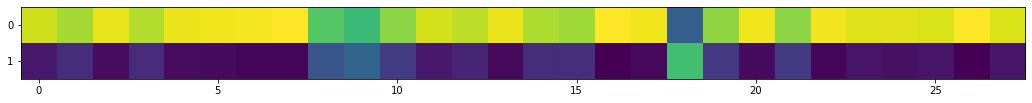

In [21]:
plt.figure(figsize=(18, 3))


In [22]:
res['start_logits'].argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Instance with fields:
 	 context: TextField of length 25 with text: 
 		[[CLS], people,, including, fictional, [SEP], Al, Gore, 's, top, campaign, aides, ,, his, children,
		,, Republican, senators, and, congressmen, ,, they, were, all, there, .]
 		and TokenIndexers : {'tokens': 'PretrainedBertIndexer'} 
 	 meta: MetadataField (print field.metadata to see specific information). 
 	 answer_starts: SequenceLabelField of length 25 with labels:
 		[False, False, False, False, False, True, False, False, False, False, False, False, False, False,
		False, False, False, False, False, False, False, False, False, False, False]
 		in namespace: 'labels'. 
 	 answer_ends: SequenceLabelField of length 25 with labels:
 		[False, False, False, False, False, False, False, True, False, False, False, False, False, False,
		False, False, False, False, False, False, False, False, False, False, False]
 		in namespace: 'labels'. 

PERSON
